In [80]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.patches as patches

import pylab as plt
#!pip install --user gpy 
#!pip install --user plotly 

import GPy
from IPython.display import display

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, spectral_clustering, DBSCAN
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import utils

from importlib import reload
from sklearn.model_selection import train_test_split


#GPy.plotting.change_plotting_library('plotly')
GPy.plotting.change_plotting_library('plotly_offline')

sns.set(color_codes=True)

# Gaussian Process course term project: Housing price prediction
Aarno Vuola 355085,
Martti Pankakoski 288877, 
Ahti Kalervo 84202R,

Also in GitHub: https://github.com/kaleaht/house-prices

# Intro


Housing price prediction based on historical data is difficult, as it is affected both by a multitude of house features and current economical situation. In this project we explore Helsinki municipality housing data and make predictions using Gaussian Process regression models. 

Our initial plan was to use GPs to fit and learn from the data, but this project ended up being a kind of learning experience of the pros and cons of gaussian processes and data analysis in general.


# Data

Our data set consists out of all the apartment deals made in Helsinki during the last 12 months, totaling 3432 rows. The raw data contains variables: apartment type, apartment size in $m^2$, neighborhood, price, number of rooms, year built, floor number, elevator, condition and neighborhood. We scarped the data from http://asuntojen.hintatiedot.fi/haku/. Also we enriched the data by adding location coordinates for each neighborhood and calculating the neighborhood's distance from Helsinki city center. Coordinates we fetched using Google maps API. 

### Preprocessing

For our analysis we needed to preprocess the raw dataset as the scraped raw data was not as such suitable for use. 

The following list shows the main preprocessing steps taken:


* String-valued binary choices were converted to numeric 1/0 binary features (such as the elevator 'yes/no' feature)

* Condition ('bad/ok/good') was encoded as ordinal range of 0,1,2 as it can be thought that higher value is better, meaning that ordinal encoding can be used

* Floor number was transformed into four distinct features:
     * Floor number
     * Binary variable bottom\_floor, true if floor number is one
     * Binary variable top\_floor, true if floor number is the same as amount of floors in a building
     * Floor fraction, floor number divided by the amount of floors

* Categorical variables such as house type were one-hot encoded

* Neighborhood string of the raw data was fed into Google Geocode API and resulting latitude and longitude recorded.

* Distance to city center was calculated by feeding the latitude and longitude of neighborhoods and Helsinki city center to a havesine function. This turned out to be a very important feature.

* Numerical features were left as-is.

Our preprocessed data set consisted of a total of 3327 rows with 17 features.

### Load data
Load raw data, drop some values missed in data preparation, drop unnecessary columns, show data head. See utils.load_data() function.

In [106]:
data, data_with_neighborhood = utils.load_data('data/cleaned_data2.csv')
data.head(5)

type_kt  type_rt  type_ok  elevator   price  price_per_square_meter  \
0        1        0        0         1  191050                   10055   
1        1        0        0         0  143000                    5789   
2        1        0        0         1  167000                    6680   
3        1        0        0         0  157000                    6181   
4        1        0        0         0  133000                    4926   

  number_of_rooms  square_meters  year  condition  floor_num top_floor  \
0               1           19.0  1929          2        5.0      True   
1               1           24.7  1957          1        3.0     False   
2               1           25.0  1940          1        6.0      True   
3               1           25.4  1951          1        1.0     False   
4               1           27.0  1961          2        2.0     False   

  bottom_floor  floor_frac        lat        lng  dist_center  
0        False    1.000000  60.167458  24.931075     0.485608  
1        False    0.750000  60.206704  24.871212     5.544540  
2        False    1.000000  60.188258  24.955949     2.270341  
3        False    0.250000  60.202747  24.905494     4.093763  
4        False    0.666667  60.212173  25.096109     9.939839

# Data exploration
In this section we explore the data to get a feel of the dataset and what variables affect the price of the flats.

### Plot variables
First we plot some variables to get a visual idea of the data. The goal of this project is to predict price per $m^2$, so most of the plots have that variable on y-axis. 

Some observations can immediately be made. Price/$m^2$ decreases with the distance from center, and distance from center increases per year. This is natural city develpment, where the apartments near the center are more expensive and most new apartments are built in newly developed areas further away from the center.

Price/$m^2$ also decreases with the number of rooms; This is also expected as huge apartments can't be as expensive per square meter as small one room apartments.

High coastline apartment prices are reflected in the price/$m^2$ per latitude plot. The highest prices are located near the sea, regardless of longitude.

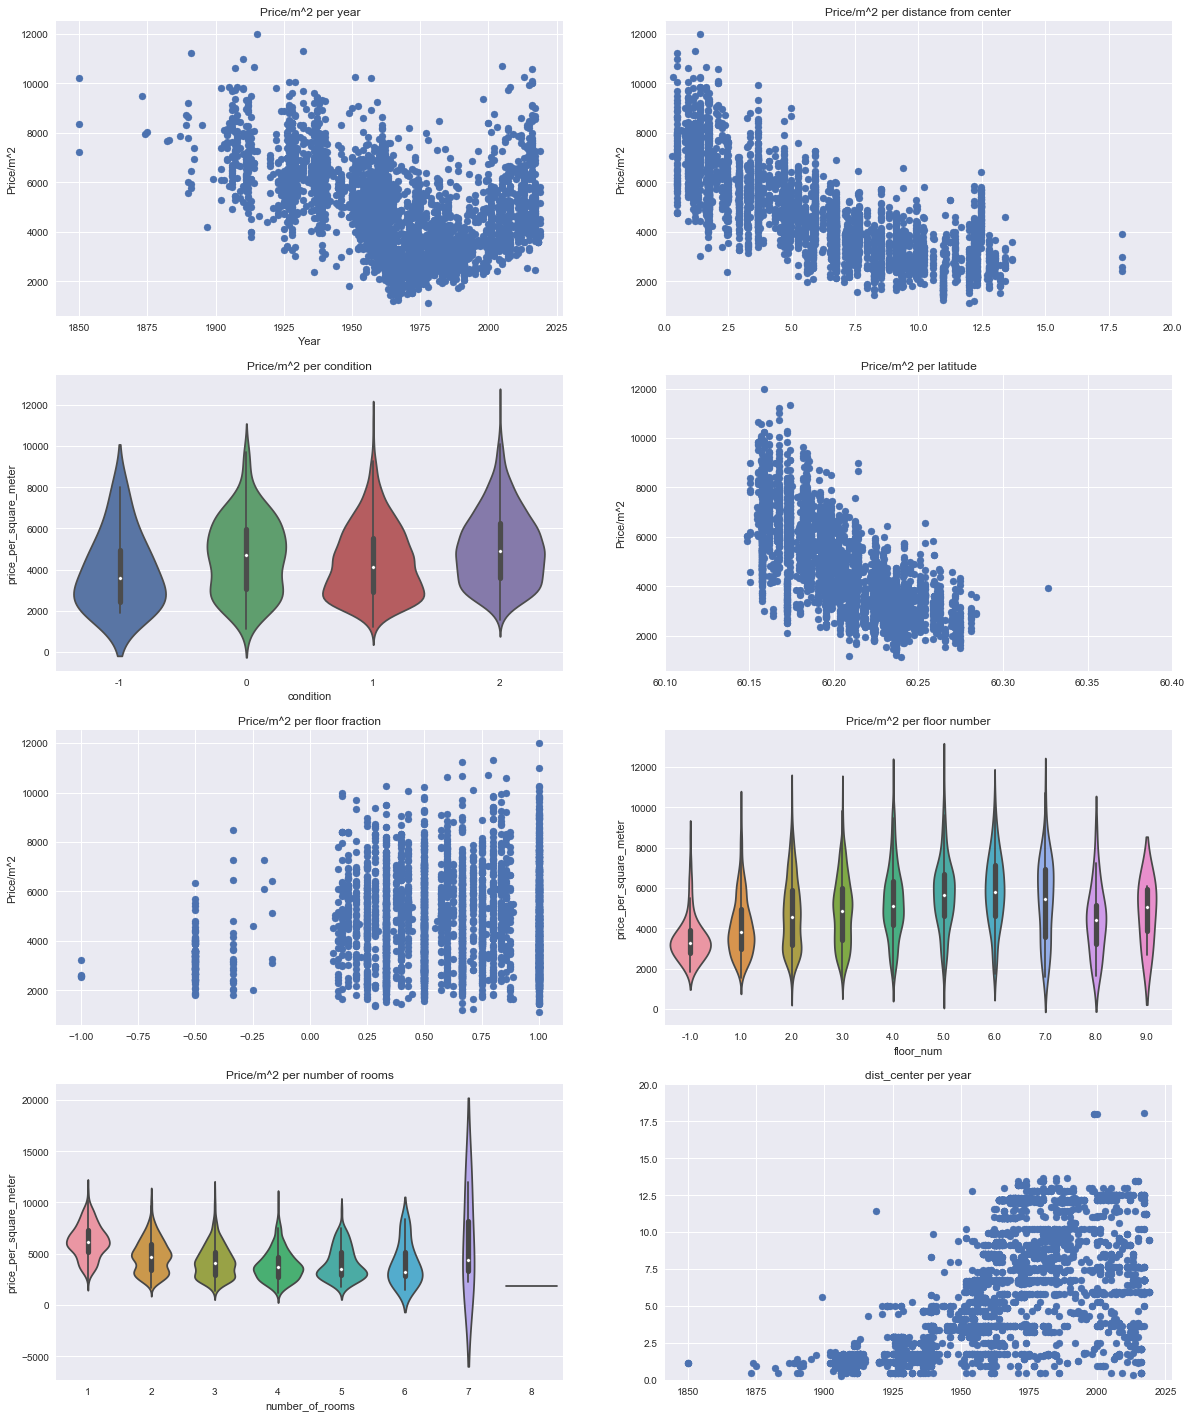

In [82]:
utils.plot_variables(data)

### Correlation plot
Correlation plot gives nice overview of the variable correlations. Interesting observations include that price per square meter and price differ on a number of variables, such as house type. This is again result from the fact that different house types are inherently of different sizes, and that price per square meter and square meters is negatively correlated.

Floor number is also positively correlated. It can perhaps be seen more clearly from the plots above but apartments higher up fetch a higher price.

Some correlations are obvious, such as elevator fetching a high price, elevator correlating with floor number, and condition correlating with price and price per square meter.

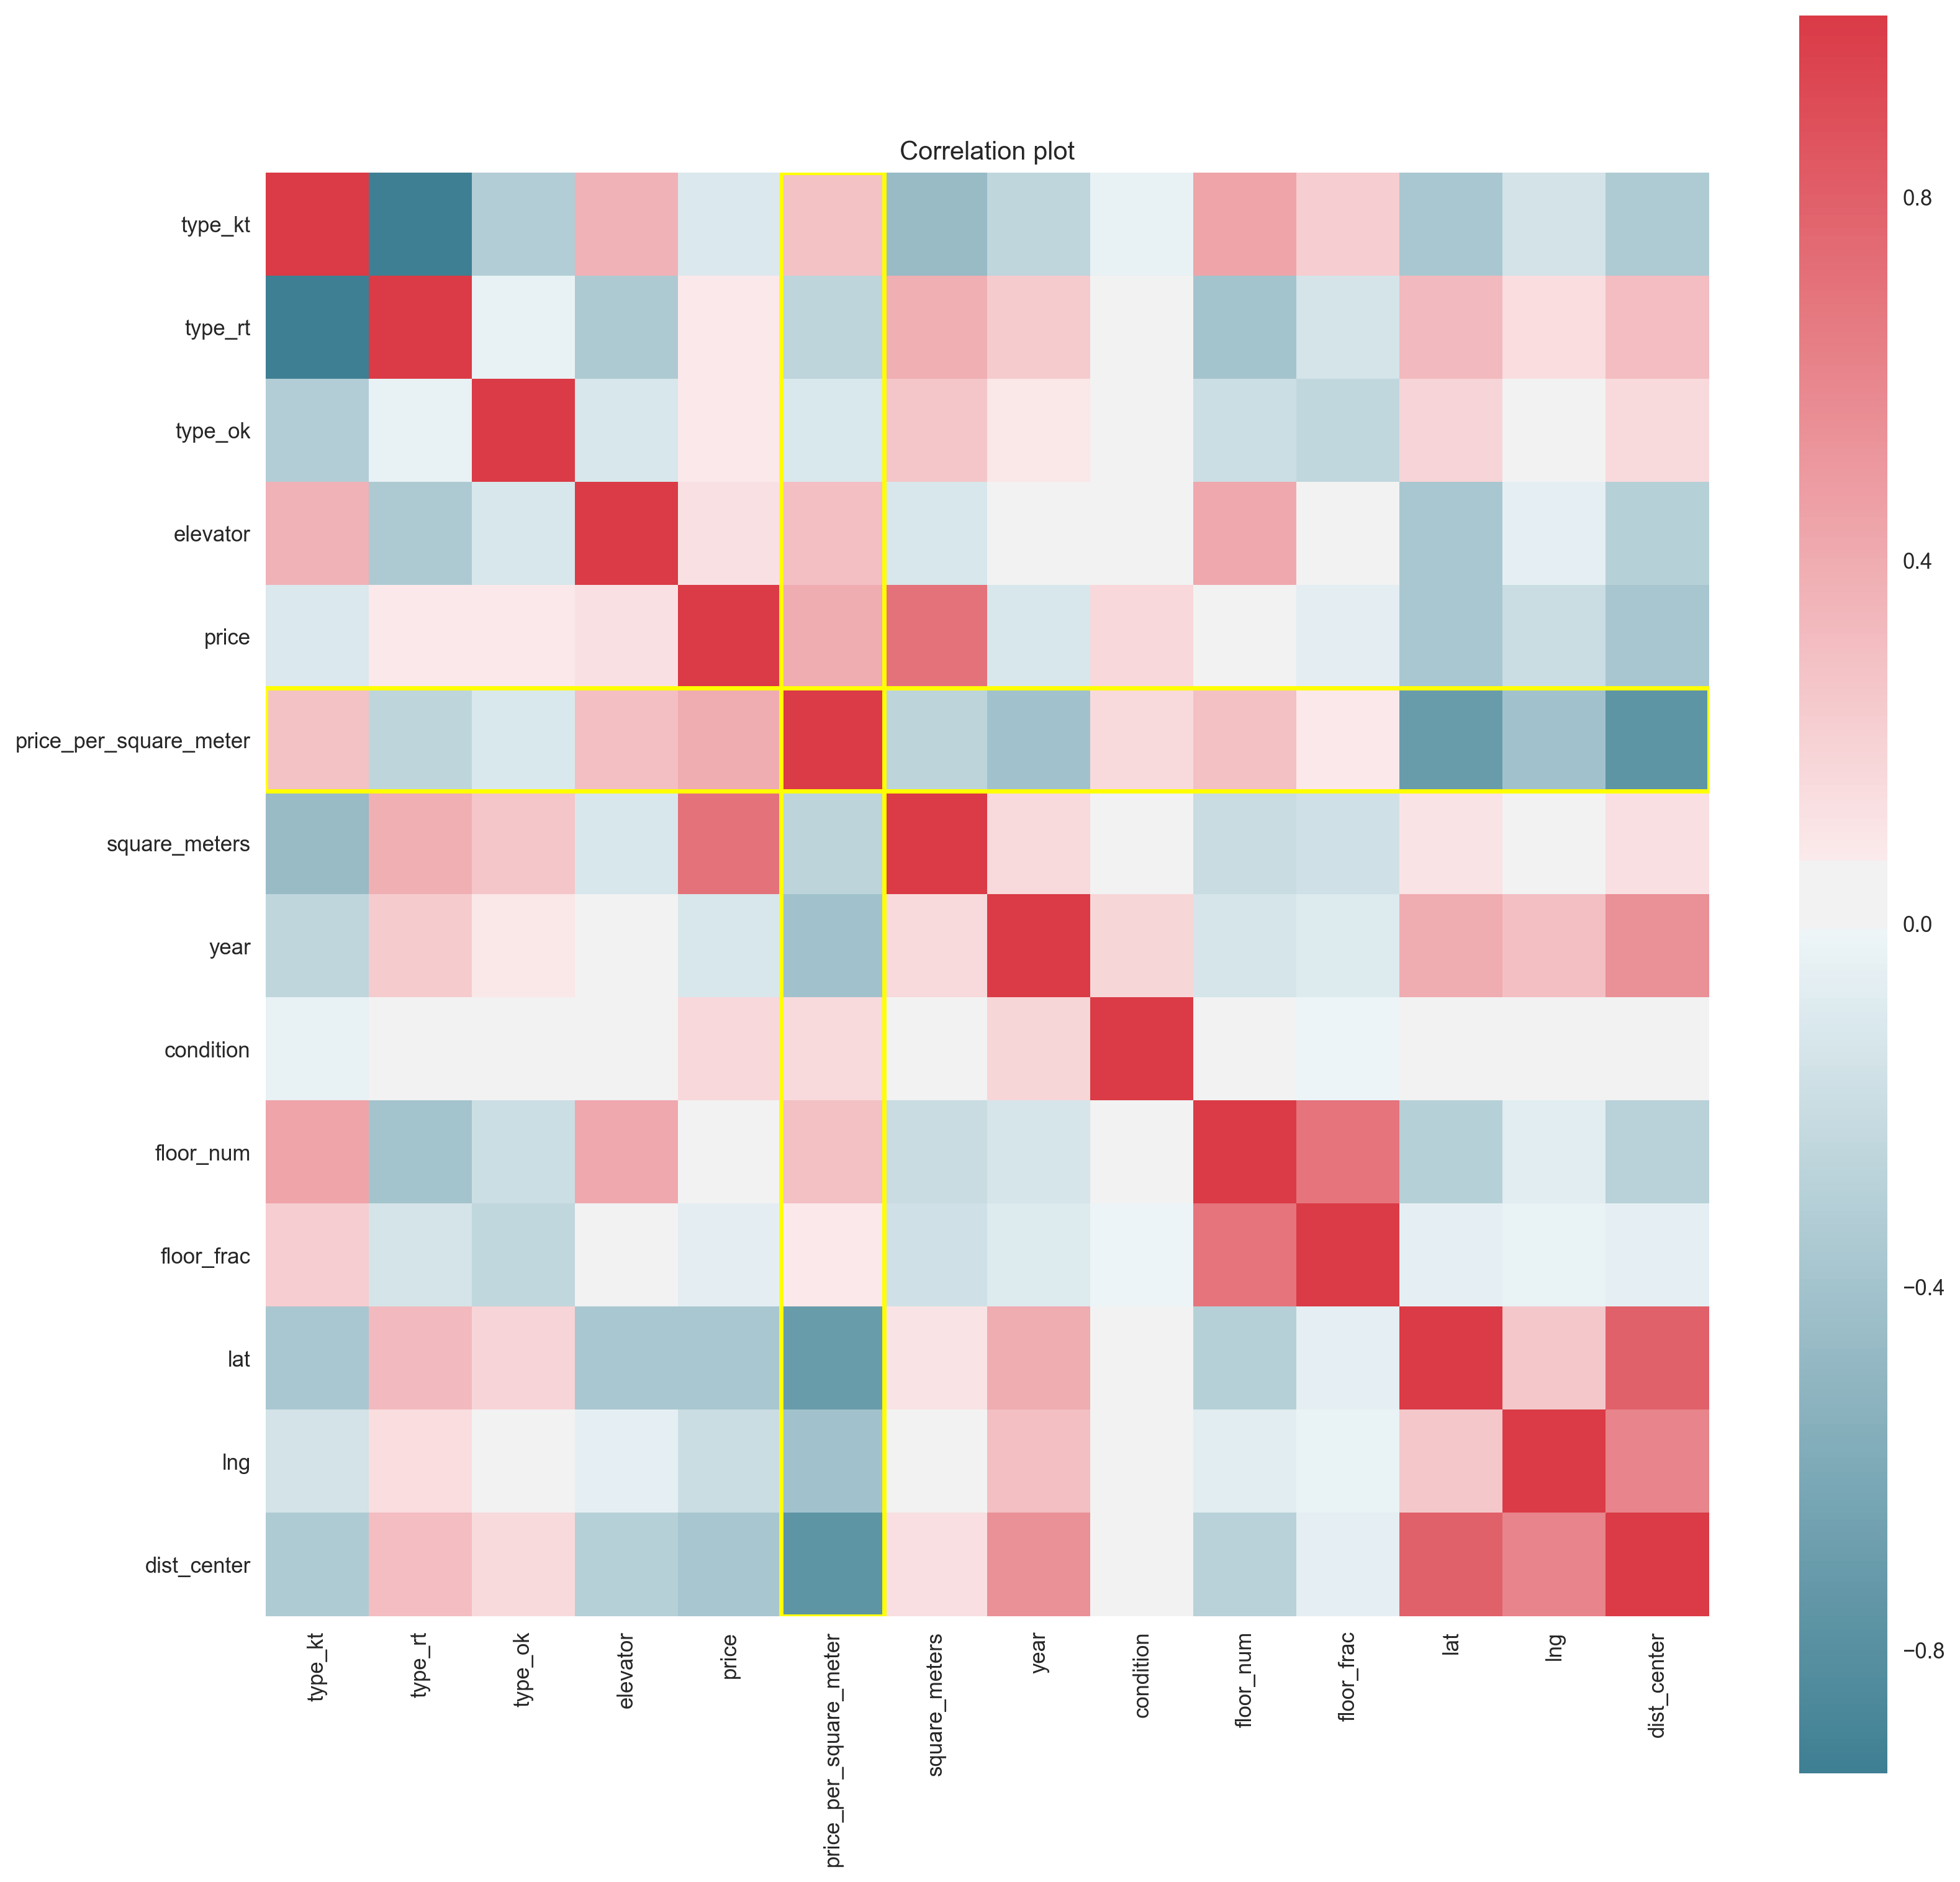

In [83]:
utils.plot_correlation(data)

### TSNE embedding
Next, we do tsne embedding to visualize the whole dataset in 2D. Price related variables are dropped as we wish to predict those variables and as such can use them to color the tsne plots to see if any clusters form where the price or price per square meter are different.

We plot a couple of more tsne plots where the coloring is some other interesting variable.

The resulting plots show somewhat neat clusters. In the bottom row, they are colored based on kmeans and DBSCAN clustering algorithm. By looking at the plot colored by year and the plot colored by distance we can see that some of the clusters mark older houses near the city center, other clusters recently built flats in great condition and still others cheap apartments far from the center.

The results suggest that neighbor or distance based models might perform well on this task. 

In [117]:
# TSNE, drop price and price per square meter as we want to predict those variables
data_tsne_embedded = TSNE(n_components=2).fit_transform(data.drop(columns=['price', 'price_per_square_meter']))

In [118]:
# Calculate kmeans and spectral clusters on the data for cluster visualization
kmeans = KMeans(n_clusters=8).fit(data_tsne_embedded)
kmeans_labels = kmeans.labels_

dbscan_labels = DBSCAN(eps=3).fit_predict(data_tsne_embedded)

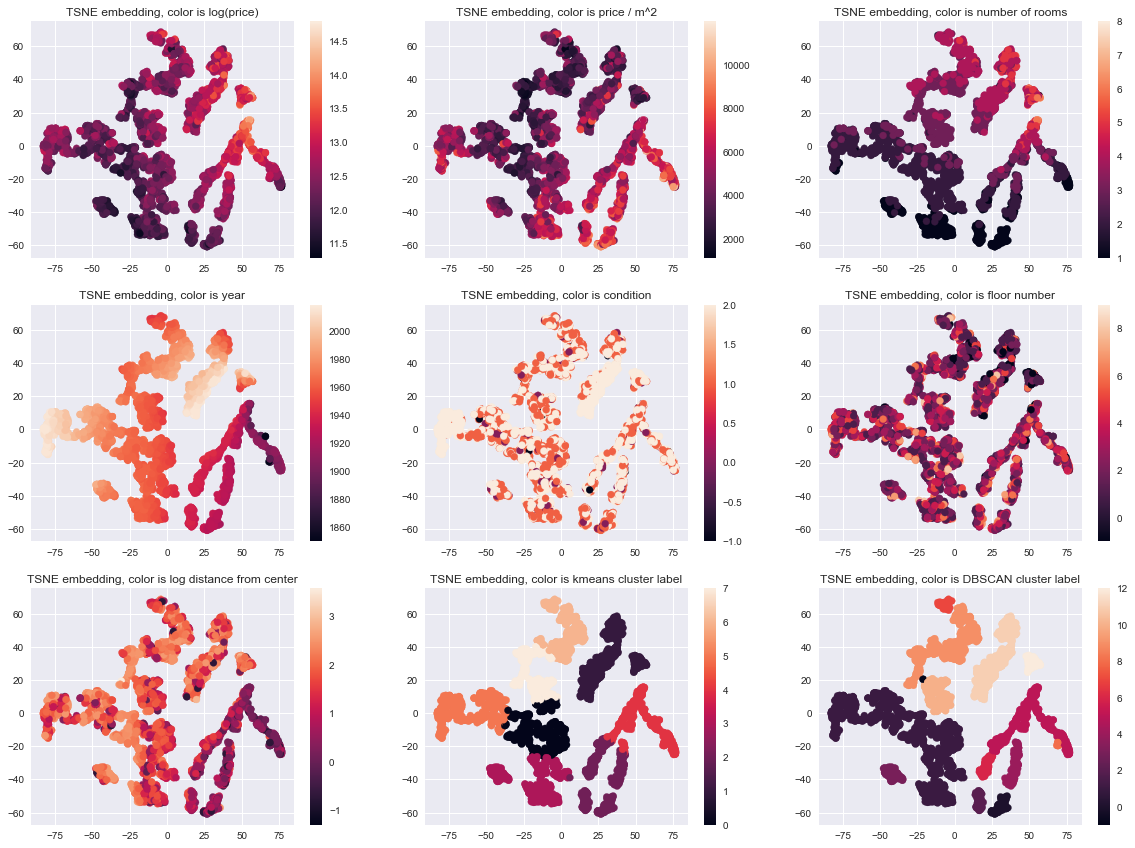

In [119]:
utils.tsne_plots(data_tsne_embedded, data, kmeans_labels, dbscan_labels)

### PCA analysis
We next do PCA analysis for the data, similarly to the TSNE embedding. We see that the first two components explain 99.1% of the variance, so most likely it would be beneficial to use just these to fit the GP. 

Explained variance for the first two principal components:
0.9925895201960613


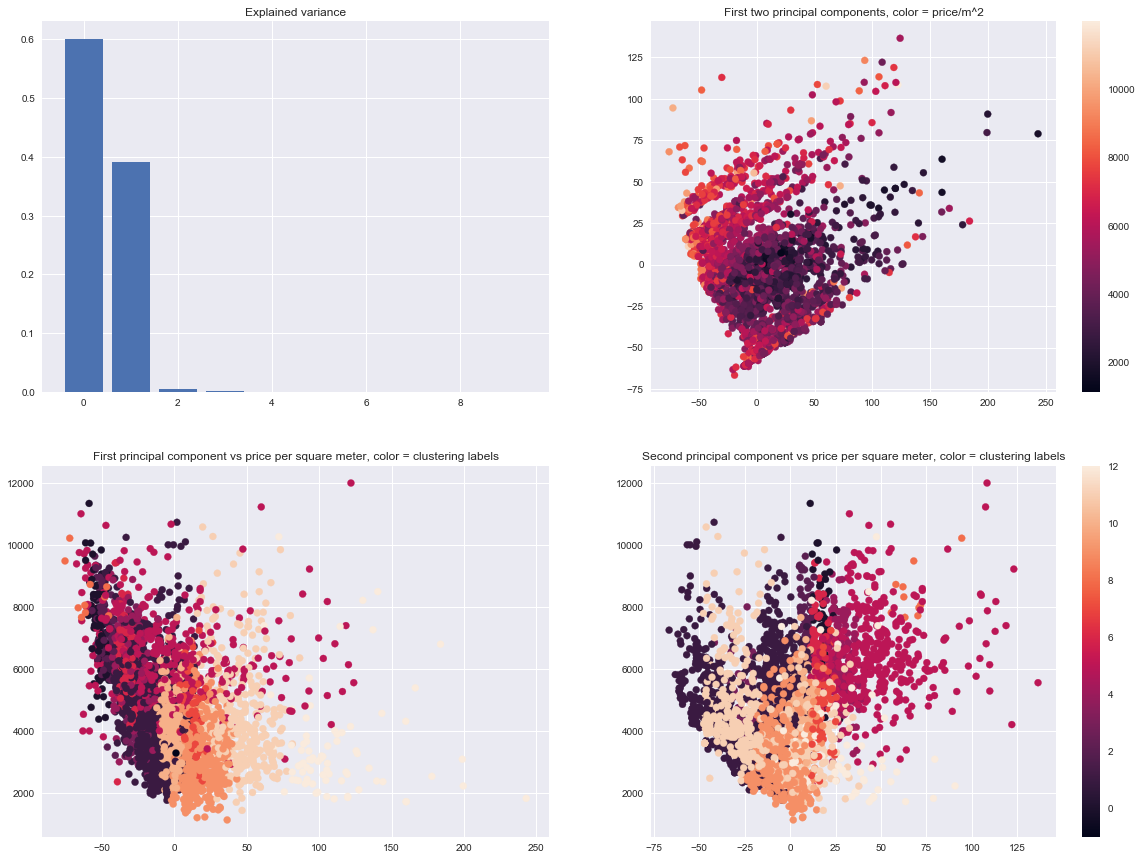

In [120]:
# TSNE, drop price and price per square meter as we want to predict those variables
pca_data = data.drop(columns=['price', 'price_per_square_meter'])

data_pca_model = PCA(n_components=10).fit(pca_data)
data_pca_embedded = PCA(n_components=10).fit_transform(pca_data)

utils.pca_plots(data_pca_model, data_pca_embedded, data, dbscan_labels)

# Model fitting

### Train-test split
We split the complete data to train and test sets. The test is set to be 20% of the whole data.

In [84]:
train_data, test_data = train_test_split(data, test_size=0.20, random_state=42)

print('Train and test set sizes:')
print(len(train_data), len(test_data))

Train and test set sizes:
2661 666


### Baseline predictions based on mean neighborhood price per square meter

As an absolutely naive approach to get a baseline result, we calculate the mean for every neighborhood in the data set and use these to predict house prices. The results are actually pretty good, indicating that the location or neighborhood of the house plays a significant role in the pricing.

In [108]:
train_neigh, test_neigh = train_test_split(data_with_neighborhood, test_size=0.33, random_state=42)

train_neigh = train_neigh[['neighborhood','price_per_square_meter']].groupby('neighborhood').mean()
res_neigh = test_neigh.join(train_neigh, lsuffix='', rsuffix='_pred', on='neighborhood')

predictions = res_neigh['price_per_square_meter_pred']
Y_test_b = res_neigh['price_per_square_meter']

mean_test_error = np.mean((Y_test_b-predictions)**2)
mean_abs_test_error = np.mean(abs((Y_test_b - predictions)))
print('\nMean squared test error:')
print(mean_test_error)
print('\nMean absolute test error:')
print(mean_abs_test_error)


Mean squared test error:
934458.452704

Mean absolute test error:
738.719500729


### Baseline models

As a baseline to reach, we train kNN, Random Forest and linear regression models. We try to surpass the performance of these models with the GPs.
They both have similar MSEs, about 300 000. We can also look at the random forest's feature importances to see which features influence the decisions the most.

Random Forest model performs the best of these models, with mean absolute error of 478 and MSE of 465685. This is better than the neighborhood-based predictions, but not significantly. K-neighbors regression and linear regression produce results close to the neighborhood predictions, which might be expected as the neighborhood prediction is a kind of nearest neighbor predictor.

We also plot histograms of the absolute test error. Again, Random Forest has the tightest histogram around the mean, while linear regression and k-neighbors has a larger variance in the predictions.

Of the Random Forest's feature importances, distance from city center is the most important feature by far. Square meters and year are the next most important features. Other features contribute little, if at all. This analysis was important, as we can later fit dedicated kernels for these dimensions.

/u/07/akalervo/unix/.conda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Mean squared error: 449176.14
Mean absolute error: 454.29
Variance score: 0.87 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
Mean squared error: 971628.17
Mean absolute error: 695.96
Variance score: 0.72 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean squared error: 1003748.67
Mean absolute error: 762.44
Variance score: 0.71 

RF feature importance


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

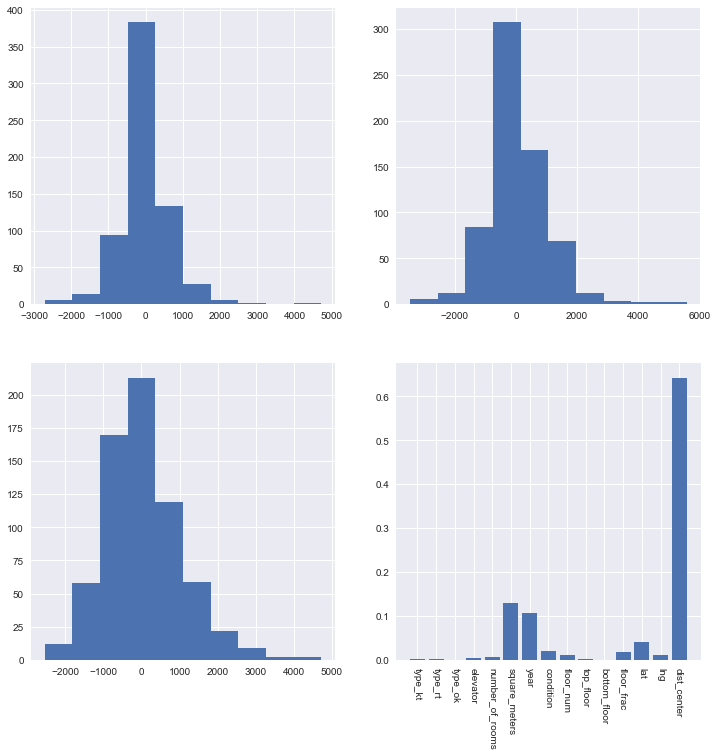

In [109]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

X_train_b = train_data.drop(columns=['price', 'price_per_square_meter'])
Y_train_b = train_data[['price_per_square_meter']]

X_test_b = test_data.drop(columns=['price', 'price_per_square_meter'])
Y_test_b = test_data[['price_per_square_meter']]

rf = RandomForestRegressor()
kn = KNeighborsRegressor()
ln = LinearRegression()

plt.figure(figsize=(12, 12))
i = 0
for model in [rf, kn, ln]:
    i+=1
    model.fit(X_train_b, Y_train_b)
    print(model)
    predictions = model.predict(X_test_b)
    try:
        diffs = np.squeeze(Y_test_b,1) - predictions
    except:
        diffs = Y_test_b - predictions
        diffs = np.squeeze(diffs,1)
    
    plt.subplot(2,2,i)
    plt.hist(diffs)
    print("Mean squared error: %.2f" % mean_squared_error(Y_test_b, predictions))
    print("Mean absolute error: %.2f" % mean_absolute_error(Y_test_b, predictions))
    print('Variance score: %.2f \n' % r2_score(Y_test_b, predictions))
    
print('RF feature importance')

plt.subplot(2,2,4)
plt.bar(range(0,15), rf.feature_importances_, tick_label = X_train_b.columns)
plt.xticks(rotation=-90)

### Baseline models for PCA data

Next we test our hypothesis that using the PCA data would be beneficial as the dimensionality is reduced to just two dimensions while retaining 99% of the variance, which should make the models simpler and as such better as per Occam's razor.

This does not seem to be the case here, however, as the errors increase significantly with all models. This might be a problem with our experiment setup, but at this point we decided to drop our original plan of solely predicting housing prices using all variables and decided to also focus on deeper exploration of how different variables affect the housing prices. For this reason, we did not pursue the PCA path further, although we did fit a GP model for the PCA data too.

In [110]:
data_pca_model = PCA(n_components=2).fit(pca_data)

# Construct pca train test sets
pca_train_X = data_pca_model.transform(train_data.drop(columns=['price', 'price_per_square_meter']))
pca_train_Y = np.array(train_data['price_per_square_meter'])[:, None]

pca_test_X = data_pca_model.transform(test_data.drop(columns=['price', 'price_per_square_meter']))
pca_test_Y = np.array(test_data['price_per_square_meter'])[:, None]

rf = RandomForestRegressor()
kn = KNeighborsRegressor()
ln = LinearRegression()


for model in [rf, kn, ln]:
    model.fit(pca_train_X, pca_train_Y)
    print(model)
    predictions = model.predict(pca_test_X)
    print("Mean squared error: %.2f" % mean_squared_error(pca_test_Y, predictions))
    print("Mean absolute error: %.2f" % mean_absolute_error(pca_test_Y, predictions))
    print('Variance score: %.2f \n' % r2_score(pca_test_Y, predictions))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Mean squared error: 1720360.34
Mean absolute error: 948.96
Variance score: 0.51 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
Mean squared error: 1697386.26
Mean absolute error: 972.59
Variance score: 0.52 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean squared error: 2658725.78
Mean absolute error: 1301.88
Variance score: 0.24 



/u/07/akalervo/unix/.conda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



# Variable exploration

Instead of trying to just fit various models to the data to predict housing prices, we now move to explore some of the more interesting variables. Our aim is to model them and gain insights of the process of how the prices actually work. 

We start with exploring how the year built variable affects housing prices.

## Linear regression

We first model the variables with simple linear regression models to get baselines. We try different orders of linear regression.

### Year built

We fit three linear models, with up to third order polynomial transforms. The first order polynomial fit is quite bad, as it does not capture the trend of newer houses costing more than houses built between 1960-1980. Second and third order polynomials are almost identical, and both fit the data nicely.

Our findings here are that the third older polynomial fits the data the best. 

In [114]:
reload(utils)
x_train = train_data[['year']]
y_train = train_data['price_per_square_meter']

x_test = test_data[['year']]
y_test = test_data['price_per_square_meter']

utils.plotLinearData(x_train, y_train, x_test, y_test, 3)

Linear regression fit of order 1
Coefficients: 
 [  0.         -24.79782477]
Mean squared error: 2860640.79
Mean absolute error: 1355.61
Variance score: 0.18


Linear regression fit of order 2
Coefficients: 
 [  0.00000000e+00  -2.65742471e+03   6.70567047e-01]
Mean squared error: 2293973.11
Mean absolute error: 1205.63
Variance score: 0.34


Linear regression fit of order 3
Coefficients: 
 [  0.00000000e+00   1.29638777e+05  -6.69640424e+01   1.15233297e-02]
Mean squared error: 2041406.55
Mean absolute error: 1118.51
Variance score: 0.42


## Distance from center
Next we move to explore the effect of distance from center on the price. Again, we fit three different polynomials to the data, and this time the first order polynomial fits almost as well as the higher orders. The negative linear trend of the distance from center is clear.

In [113]:
x_train = train_data[['dist_center']]
y_train = train_data['price_per_square_meter']

x_test = test_data[['dist_center']]
y_test = test_data['price_per_square_meter']

utils.plotLinearData(x_train, y_train, x_test, y_test, 3)

Linear regression fit of order 1
Coefficients: 
 [   0.         -366.08619168]
Mean squared error: 1374127.04
Mean absolute error: 899.08
Variance score: 0.61


Linear regression fit of order 2
Coefficients: 
 [   0.        -791.3853642   32.3804797]
Mean squared error: 1250416.33
Mean absolute error: 864.62
Variance score: 0.64


Linear regression fit of order 3
Coefficients: 
 [  0.00000000e+00  -7.28866515e+02   2.15488008e+01   5.10626988e-01]
Mean squared error: 1247729.62
Mean absolute error: 863.08
Variance score: 0.64


# Gaussian processes for price prediction
We now move to do these same experiments with Gaussian Processes. First, we show fitted models for the individual variables and then what was achieved when using all of the features.

We compare the models using mean square error (MSE), mean absolute error, variance score and mean log pointwise predictive density (MLPPD). 

### GP for price prediction year built

We used two rbf and bias kernels. The result looks  like the third order polynomial we fitted earlier, but with the other rbf kernel with smaller length scale we are able to capture small fluctuations in the price. An other benefit of Gaussian Processes is that we get he confidence intervals which are beneficial. The overall results are better than in the linear regression.

In [115]:
X_train = np.array(train_data[['year']])
Y_train = np.array(train_data['price_per_square_meter'])[:, None]

X_test = np.array(test_data[['year']])
Y_test = np.array(test_data['price_per_square_meter'])[:, None]

rbf = GPy.kern.RBF(input_dim=X_train.shape[1], lengthscale=100) 

rbf2 = GPy.kern.RBF(input_dim=X_train.shape[1], lengthscale=10) 

bias = GPy.kern.Bias(1)

kernel = rbf + rbf2 + bias

m = GPy.models.GPRegression(X_train, Y_train, kernel, normalizer=True)
m.optimize(messages=True)
reload(utils)
utils.model_information(m, X_test, Y_test, plot_test_data = True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    09s64  0005   2.924575e+03   5.751500e+00 
    30s33  0016   2.916824e+03   1.916124e+04 
 01m28s02  0047   2.879886e+03   1.100525e+02 
 01m47s30  0057   2.876288e+03   1.579907e-01 
 03m05s66  0098   2.871313e+03   1.783728e+03 

/u/07/akalervo/unix/.local/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/07/akalervo/unix/.local/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square

/u/07/akalervo/unix/.local/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:

invalid value encountered in multiply



 03m07s64  0099   3.891871e+03           nan 

/u/07/akalervo/unix/.local/lib/python3.6/site-packages/paramz/optimization/verbose_optimization.py:160: RuntimeWarning:

invalid value encountered in less



 03m11s64  0101   2.871313e+03   1.783728e+03 
Runtime:  03m11s64
Optimization status: Converged




Name : GP regression
Objective : 2871.313401465661
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |            value  |  constraints  |  priors
  sum.rbf.variance         |    1.23628122805  |      +ve      |        
  sum.rbf.lengthscale      |    38.0694528681  |      +ve      |        
  sum.rbf_1.variance       |  0.0680779735025  |      +ve      |        
  sum.rbf_1.lengthscale    |    1.07634863537  |      +ve      |        
  sum.bias.variance        |  0.0112793352261  |      +ve      |        
  Gaussian_noise.variance  |   0.500204383729  |      +ve      |        

Log marginal likelihood:
-2871.31340147
(666, 1)

Mean squared error: 1862962.17

Mean absolute error: 1047.25

Variance score: 0.47

MLPPD:
-26539285.0779
This is the format of your plot grid:
[ (1,1) x1,y1 ]



### GP for price prediction distance from the center

We used only rbf and bias kernels. The overall trend in the plot is clear  the further away the apartments is from the city center the lower the price is. However, since the distances are essentially categorical, because all sales from a certain neighborhood have the same distance, the GP is evaluating a categorical mean. This accounts for a lack of smoothness in the plot.

The overall results are again better than in the linear regression.

In [121]:
X_train = np.array(train_data[['dist_center']])
Y_train = np.array(train_data['price_per_square_meter'])[:, None]

X_test = np.array(test_data[['dist_center']])
Y_test = np.array(test_data['price_per_square_meter'])[:, None]

rbf = GPy.kern.RBF(input_dim=X_train.shape[1]) 

bias = GPy.kern.Bias(1)

kernel = rbf + bias

m = GPy.models.GPRegression(X_train, Y_train, kernel, normalizer=True)
m.optimize(messages=True)
reload(utils)
utils.model_information(m, X_test, Y_test, plot_test_data = True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    10s82  0009   2.366314e+03   5.580164e+04 
    33s19  0027   2.242097e+03   4.052348e+01 
    38s18  0031   2.241299e+03   1.866874e-01 
    44s13  0036   2.241297e+03   1.934544e-04 
Runtime:     44s13
Optimization status: Converged




Name : GP regression
Objective : 2241.2966684861285
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |            value  |  constraints  |  priors
  sum.rbf.variance         |   0.754919230418  |      +ve      |        
  sum.rbf.lengthscale      |   0.116108398927  |      +ve      |        
  sum.bias.variance        |  0.0131293243449  |      +ve      |        
  Gaussian_noise.variance  |   0.282396935078  |      +ve      |        

Log marginal likelihood:
-2241.29666849
(666, 1)

Mean squared error: 1069260.51

Mean absolute error: 788.58

Variance score: 0.69

MLPPD:
-47000536.122
This is the format of your plot grid:
[ (1,1) x1,y1 ]



## GP for PCA data
Our original idea was to predict housing prices using all of the variables, so PCA was thought to be beneficial.

As the first two principal components account for 99% of the variance, we fit a GP to this transform. Now the GP is two dimensional, which makes constructing kernels more difficult but on the other hand this should be easier than with all the different dimensions.

The resulting predictions are worse than the baseline predictions as the PCA data can not really be separated in any coherent way without overfitting harshly. Due to this, the predictions are off by a large margin. However, the results are little better than with the baseline PCA models, indicating that the GP model works in this case better and should be chosen if this setup was something we wanted to do.

In [122]:
data_pca_model = PCA(n_components=2).fit(pca_data)

# Construct pca train test sets
pca_train_X = data_pca_model.transform(train_data.drop(columns=['price', 'price_per_square_meter']))
pca_train_Y = np.array(train_data['price_per_square_meter'])[:, None]

pca_test_X = data_pca_model.transform(test_data.drop(columns=['price', 'price_per_square_meter']))
pca_test_Y = np.array(test_data['price_per_square_meter'])[:, None]

In [123]:
rbf = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1., active_dims=[0,1])
bias = GPy.kern.Bias(input_dim=X_train.shape[1])
kernel = rbf + bias 

m = GPy.models.GPRegression(pca_train_X, pca_train_Y, kernel, normalizer=True)
m.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    10s13  0008   2.750900e+03   1.354690e+04 
    20s59  0016   2.692142e+03   1.642166e+01 
    34s30  0027   2.691576e+03   7.236709e-02 
    38s00  0030   2.691575e+03   8.788145e-08 
    39s23  0031   2.691575e+03   8.788145e-08 
Runtime:     39s23
Optimization status: Converged



In [124]:
utils.model_information(m, pca_test_X, pca_test_Y, plot_test_data = False)


Name : GP regression
Objective : 2691.5749666295883
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  sum.rbf.variance         |  0.745925314689  |      +ve      |        
  sum.rbf.lengthscale      |   16.4660907398  |      +ve      |        
  sum.bias.variance        |  0.126060950356  |      +ve      |        
  Gaussian_noise.variance  |  0.405193910441  |      +ve      |        

Log marginal likelihood:
-2691.57496663
(666, 1)

Mean squared error: 1567774.96

Mean absolute error: 948.47

Variance score: 0.55

MLPPD:
-32276518.9488
This is the format of your plot grid:
[ (1,1) x1,y1 ]



## GP for all variables

This experiment uses 15 columns of 17 to predict prices per square meter (excluding price per square meter and price). The model performed better than all baseline models except for random forest. The random forest model had a mean absolute error of 454.29 and a variance score of 0.87, while our best GP model had a mean absolute error of 458.70 and a variance score of 0.88.  We used a total of five kernels for the model - three rbf kernels for numeric features ("year", "square meters" and "distance from center"), one rbf kernel for the rest of the features and a bias kernel. We also tested creating RBF ARD kernels for the categorical features but these decreased performance (The Kernel Cookbook - https://www.cs.toronto.edu/~duvenaud/cookbook/). The computational time increased significantly when individual kernels were created for specific dimensions.

In [104]:
train_X = train_data.drop(columns=['price', 'price_per_square_meter'])
train_Y = np.array(train_data['price_per_square_meter'])[:, None]

test_X = test_data.drop(columns=['price', 'price_per_square_meter'])
test_Y = np.array(test_data['price_per_square_meter'])[:, None]
print(train_X.columns)
print(len(train_X.columns)-1)

Index(['type_kt', 'type_rt', 'type_ok', 'elevator', 'number_of_rooms',
       'square_meters', 'year', 'condition', 'floor_num', 'top_floor',
       'bottom_floor', 'floor_frac', 'lat', 'lng', 'dist_center'],
      dtype='object')
14


In [94]:
rbf_dist_center = GPy.kern.RBF(input_dim=1, active_dims=[14])

rbf_year = GPy.kern.RBF(input_dim=1, active_dims=[6])

rbf = GPy.kern.RBF(input_dim=7, active_dims=[4,5,7,8,10,11,12])

cat_house_type = GPy.kern.RBF(input_dim=3, active_dims=[0,1,2], ARD=True)

cat_elev = GPy.kern.RBF(input_dim=1, active_dims=[3], ARD=True)

cat_bot_floor = GPy.kern.RBF(input_dim=1, active_dims=[10], ARD=True)

cat_top_floor = GPy.kern.RBF(input_dim=1, active_dims=[9], ARD=True)

bias = GPy.kern.Bias(input_dim=X_train.shape[1])

kernel = bias + rbf + rbf_dist_center + rbf_year + cat_house_type + cat_elev + cat_bot_floor + cat_top_floor

m = GPy.models.GPRegression(train_X, train_Y, kernel, normalizer=True)
m.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    35s03  0007   1.636608e+03   8.312377e+03 
 01m54s18  0023   1.474854e+03   7.785277e+02 
 04m52s79  0059   1.456250e+03   2.133220e-01 
 09m29s20  0115   1.456161e+03   1.772526e-03 
 13m54s12  0169   1.455801e+03   5.293549e-04 
Runtime:  13m54s12
Optimization status: Converged



In [95]:
utils.model_information(m, np.asarray(test_X), test_Y, plot_test_data = False, plot_data=False)


Name : GP regression
Objective : 1455.8013069572714
Number of Parameters : 18
Number of Optimization Parameters : 18
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  sum.bias.variance        |  1.25226232814e-18  |      +ve      |        
  sum.rbf.variance         |      29.8035166948  |      +ve      |        
  sum.rbf.lengthscale      |      54.6684917542  |      +ve      |        
  sum.rbf_1.variance       |     0.534096973586  |      +ve      |        
  sum.rbf_1.lengthscale    |      1.42648940265  |      +ve      |        
  sum.rbf_2.variance       |    0.0873739396447  |      +ve      |        
  sum.rbf_2.lengthscale    |      1.06734481339  |      +ve      |        
  sum.rbf_3.variance       |    0.0222017677717  |      +ve      |        
  sum.rbf_3.lengthscale    |               (3,)  |      +ve      |        
  sum.rbf_4.variance       |    0.0371203744852  |      +ve      |        
  sum.rbf_4.lengthscale    |  

In [102]:
rbf_dist_center = GPy.kern.RBF(input_dim=1, active_dims=[14])

rbf_size = GPy.kern.RBF(input_dim=1, active_dims=[5])

rbf_year = GPy.kern.RBF(input_dim=1, active_dims=[6])

rbf = GPy.kern.RBF(input_dim=12, active_dims=[0,1,2,3,4,7,8,9,10,11,12,13])

bias = GPy.kern.Bias(input_dim=X_train.shape[1])

kernel = bias + rbf + rbf_dist_center + rbf_size + rbf_year

m = GPy.models.GPRegression(train_X, train_Y, kernel, normalizer=True)
m.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    06s04  0002   2.468986e+03   4.455565e+05 
    27s91  0009   1.510863e+03   8.962603e+02 
 01m23s59  0027   1.400679e+03   3.930410e+01 
 03m55s17  0077   1.178073e+03   1.637866e+02 
 05m58s79  0118   1.172936e+03   1.056943e-01 
 09m00s99  0178   1.169199e+03   3.297370e-01 
 12m13s05  0240   1.169135e+03   6.723524e-03 
 12m28s61  0245   1.169135e+03   2.915236e-03 
Runtime:  12m28s61
Optimization status: Converged



In [103]:
utils.model_information(m, np.asarray(test_X), test_Y, plot_test_data = False, plot_data=False)


Name : GP regression
Objective : 1169.1348103880537
Number of Parameters : 10
Number of Optimization Parameters : 10
Updates : True
Parameters:
  GP_regression.           |             value  |  constraints  |  priors
  sum.bias.variance        |  0.00012975942225  |      +ve      |        
  sum.rbf.variance         |    0.672117804116  |      +ve      |        
  sum.rbf.lengthscale      |     4.53535876387  |      +ve      |        
  sum.rbf_1.variance       |    0.560492208751  |      +ve      |        
  sum.rbf_1.lengthscale    |   0.0131306689949  |      +ve      |        
  sum.rbf_2.variance       |     1.73497118511  |      +ve      |        
  sum.rbf_2.lengthscale    |     32.0203967018  |      +ve      |        
  sum.rbf_3.variance       |   0.0867298488139  |      +ve      |        
  sum.rbf_3.lengthscale    |     7.24163362773  |      +ve      |        
  Gaussian_noise.variance  |    0.108040016079  |      +ve      |        

Log marginal likelihood:
-1169.13481039


# Discussion

We set out to predict housing prices with Gaussian Process using data we had scraped ourselves. Significant time was spent obtaining and preprocessing the data to get an usable dataset. Visualization of the dataset revealed useful information on variable dependencies, which ultimately led us to choose to mostly concentrate on experimenting with just a few of the variables. However, in the end of project we attempted to create individual kernels for dimensions using all variables and achieved good results by almost matching the best baseline model.

The course mainly taught using GPs with single dimension, so we decided to model the $price/m^2$ dependency on year and distance from center. We compared these result to baseline linear models, and turns out the results were very similar but with confidence levels.

When using only distance from center as the predictor, the GP model outperformed the baseline linear models and with quite low error as well. However, it did not reach our naive baseline (mean neighborhood $price/m^2$) performance, which is odd as the distances should be the same for same neighborhoods.

We also fit GPs and baseline models to all variables and PCA transformations. Our initial thought was that as PCA's first two components accounted for 99% of the variance, models would perform better when working on just these two dimensions rather than the complete dataset. This was not the case however, as for unknown reason both the baseline and GP models performed significantly worse on the transformed data. 

The GP fit to all variables was outperformed by the random forest model. For this last Gaussian process we used kernels for three single dimensions, which were selected from the random forest feature significance plot. These dimension specific kernels helped significantly in achieving good performance.

# Conclusion

Predicting housing prices is not easy. The data collection and preprocessing stage was lengthy because we had a scraped dataset which as such was not adaptable for Gaussian processes. Also a significant amount of time went into data cleansing.

We suspect adding more variables would significantly improve predictions. Such variables might include economic situation indicator variables or general sentiment on house buying for a given moment. However, we managed to find some good indicators for the price and these could be used when deciding what amount to ask when selling a flat.

We are not experts in the Helsinki real estate market, but through our data analysis on the dataset prior to using Gaussian Processes we were able to understand some phenomena behind the data. We believe this helped us in creating kernels and achieving good results. Creating priors and better constrains on kernels could improve results further.